# Visualizing Models Data And Training With Tensorboard
Adapted from [PyTorch.org](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)

In the [60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), we show you how to load in data, feed it through a model we define as a subclass of ``nn.Module``, train this model on training data, and test it on test data. To see what’s happening, we print out some statistics as the model is training to get a sense for whether training is progressing. However, we can do much better than that: PyTorch integrates with TensorBoard, a tool designed for visualizing the results of neural network training runs. This tutorial illustrates some of its functionality, using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) which can be read into PyTorch using torchvision.datasets.

In this tutorial, we’ll learn how to:

1. Read in data and with appropriate transforms (nearly identical to the prior tutorial).
2. Set up TensorBoard.
3. Write to TensorBoard.
4. Inspect a model architecture using TensorBoard.
5. Use TensorBoard to create interactive versions of the visualizations we created in last tutorial, with less code

Specifically, on point #5, we’ll see:

* A couple of ways to inspect our training data
* How to track our model’s performance as it trains
* How to assess our model’s performance once it is trained.

We’ll begin with similar boilerplate code as in the [CIFAR-10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html):


**Note** Install Tensorboard first

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

We’ll define the same ``optimizer`` and ``criterion`` from before:

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 1. TensorBoard setup
Now we’ll set up TensorBoard, importing ``tensorboard`` from ``torch.utils`` and defining a ``SummaryWriter``, our key object for writing information to TensorBoard.

In [4]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

Note that this line alone creates a ``runs/fashion_mnist_experiment_1`` folder.

## 2. Writing to TensorBoard
Now let’s write an image to our TensorBoard - specifically, a grid - using [make_grid](https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid).

torch.Size([4, 1, 28, 28])
torch.Size([3, 32, 122])


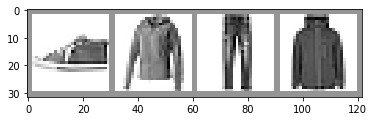

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.size())

# create grid of images
img_grid = torchvision.utils.make_grid(images)

print(img_grid.size())

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

Now running ``tensorboard --logdir=runs``

from the command line and then navigating to https://localhost:6006 should show the following.

Now you know how to use TensorBoard! This example, however, could be done in a Jupyter Notebook - where TensorBoard really excels is in creating interactive visualizations. We’ll cover one of those next, and several more by the end of the tutorial.

## 3. Inspect the model using TensorBoard
One of TensorBoard’s strengths is its ability to visualize complex model structures. Let’s visualize the model we built.

In [6]:
writer.add_graph(net, images)
writer.close()

Now upon refreshing TensorBoard you should see a “Graphs” tab that looks like this:

Go ahead and double click on “Net” to see it expand, seeing a detailed view of the individual operations that make up the model.

TensorBoard has a very handy feature for visualizing high dimensional data such as image data in a lower dimensional space; we’ll cover this next.

## 4. Adding a “Projector” to TensorBoard
We can visualize the lower dimensional representation of higher dimensional data via the [add_embedding](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_embedding) method

In [7]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

Now in the “Projector” tab of TensorBoard, you can see these 100 images - each of which is 784 dimensional - projected down into three dimensional space. Furthermore, this is interactive: you can click and drag to rotate the three dimensional projection. Finally, a couple of tips to make the visualization easier to see: select “color: label” on the top left, as well as enabling “night mode”, which will make the images easier to see since their background is white:

Now we’ve thoroughly inspected our data, let’s show how TensorBoard can make tracking model training and evaluation clearer, starting with training.

## 5. Tracking model training with TensorBoard
In the previous example, we simply printed the model’s running loss every 2000 iterations. Now, we’ll instead log the running loss to TensorBoard, along with a view into the predictions the model is making via the plot_classes_preds function.

In [8]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

Finally, let’s train the model using the same model training code from the prior tutorial, but writing results to TensorBoard every 1000 batches instead of printing to console; this is done using the add_scalar function.

In addition, as we train, we’ll generate an image showing the model’s predictions vs. the actual results on the four images included in that batch.

In [9]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


You can now look at the scalars tab to see the running loss plotted over the 15,000 iterations of training:

In addition, we can look at the predictions the model made on arbitrary batches throughout learning. See the “Images” tab and scroll down under the “predictions vs. actuals” visualization to see this; this shows us that, for example, after just 3000 training iterations, the model was already able to distinguish between visually distinct classes such as shirts, sneakers, and coats, though it isn’t as confident as it becomes later on in training:

In the prior tutorial, we looked at per-class accuracy once the model had been trained; here, we’ll use TensorBoard to plot precision-recall curves (good explanation [here](https://www.scikit-yb.org/en/latest/api/classifier/prcurve.html)) for each class.

## 6. Assessing trained models with TensorBoard

In [10]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

You will now see a “PR Curves” tab that contains the precision-recall curves for each class. Go ahead and poke around; you’ll see that on some classes the model has nearly 100% “area under the curve”, whereas on others this area is lower:

And that’s an intro to TensorBoard and PyTorch’s integration with it. Of course, you could do everything TensorBoard does in your Jupyter Notebook, but with TensorBoard, you gets visuals that are interactive by default.